In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
%load_ext version_information
%version_information numpy, dlib, matplotlib, imageio, gaze, torch, torchvision

Software,Version
Python,3.6.9 64bit [GCC 8.4.0]
IPython,7.8.0
OS,Linux 4.15.0 108 generic x86_64 with Ubuntu 18.04 bionic
numpy,1.17.2
dlib,19.19.0
matplotlib,3.1.1
imageio,2.6.1
gaze,The 'gaze' distribution was not found and is required by the application
torch,1.5.1
torchvision,0.6.1


# training the model on the cropped faces

In [4]:
from gaze import init

In [5]:
date = '20200707'
epochs = 400
args = init(verbose=1, epochs=epochs, fullsize=10,
            conv1_dim=5, conv1_kernel_size=4, conv2_dim=15, conv2_kernel_size=5,
            dataset_faces_folder='dataset_faces_%s'%date)

path = 'Regard_400_%s.pt'%date

In [6]:
print('Parameters=', args)
!ls -l {path}

Parameters= Namespace(N_cv=20, activation='relu', batch_size=16, conv1_bn_momentum=0.5, conv1_dim=5, conv1_kernel_size=4, conv2_bn_momentum=0.5, conv2_dim=15, conv2_kernel_size=5, crop=75, dataset_faces_folder='dataset_faces_20200707', dataset_folder='dataset', dense_bn_momentum=0.5, dimension=30, do_adam=False, epochs=400, fullsize=10, log_interval=0, lr=0.01, mean=0.4, momentum=0.05, no_cuda=False, num_processes=1, seed=42, size=40, size_test_set=0.2, std=0.3, stride1=2, stride2=4, test_batch_size=16, verbose=1)
-rw-rw-r-- 1 chloe chloe 110323 Jul  7 13:01 Regard_400_20200707.pt


In [7]:
from gaze import ML
ml = ML(args)
ml.train(path=path)

Found 2679 sample images;  2144  to train 535 to test
Loading file Regard_400_20200707.pt


## testing the model

In [8]:
Accuracy = ml.test()
print('Accuracy={:.1f}%'.format(Accuracy*100))

Accuracy=97.9%


## showing the images which are wrongly classified

In [9]:
import time
import os
import glob
import imageio
from LeCheapEyeTracker.EyeTrackerServer import FaceExtractor
#from gaze import FaceExtractor #/!\ ImportError
FE = FaceExtractor()
timings = []
wrongs = []
for target in ml.dataset.classes:
    print(target, args.dataset_folder)
    for filename in glob.glob(os.path.join(args.dataset_folder, target, '*.png')):
        
        if False:
            frame = imageio.imread(filename)
            img_face = FE.face_extractor(frame)
        else:
            filename_face = filename.replace(args.dataset_folder, args.dataset_faces_folder)
            img_face = imageio.imread(filename_face)

        pred = ml.classify(img_face, ml.dataset.test_transform)
        pred_label = ml.dataset.dataset.classes[pred.argmax()]
       
        if not pred_label == target:
            wrong = dict(filename=filename, pred_label=pred_label, target=target)
            wrongs.append(wrong)
            print('For ', filename, ', Pred=', pred_label, ' True=', target, ', P=', [round(p, 3) for p in pred], sep='')
            #plt.imshow(img_face)
            #plt.show()

blink dataset
For dataset/blink/2019-05-16_Laurent_134.png, Pred=center True=blink, P=[0.061, 0.934, 0.0, 0.005]
For dataset/blink/2018-09-14_Laurent_001.png, Pred=right True=blink, P=[0.0, 0.0, 0.011, 0.988]
center dataset
For dataset/center/2018-10-18_Laurent_237.png, Pred=right True=center, P=[0.0, 0.078, 0.0, 0.922]
For dataset/center/2018-10-15_Laurent_139.png, Pred=left True=center, P=[0.0, 0.079, 0.921, 0.0]
left dataset
For dataset/left/2018-10-15_Laurent_077.png, Pred=center True=left, P=[0.0, 0.685, 0.315, 0.0]
For dataset/left/2018-09-04_Laurent_216.png, Pred=center True=left, P=[0.0, 0.997, 0.003, 0.0]
For dataset/left/2018-09-12_Laurent_076.png, Pred=center True=left, P=[0.0, 0.987, 0.013, 0.0]
For dataset/left/2018-09-12_Laurent_067.png, Pred=center True=left, P=[0.0, 1.0, 0.0, 0.0]
For dataset/left/2019-05-16_Laurent_197.png, Pred=center True=left, P=[0.0, 0.703, 0.008, 0.289]
For dataset/left/2018-10-15_Laurent_200.png, Pred=center True=left, P=[0.0, 0.914, 0.086, 0.0]


In [10]:
len(wrongs)

10

## skim through images which were wrongly classified

Some images were obviously misclassified at the supervision level, let's try to fix that.

In [11]:
def view_image(wrong):
    filename = wrong['filename']
    #filename_face = filename.replace(args.dataset_folder, args.dataset_faces_folder)
    img_face = imageio.imread(filename)#_face)
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    ax.imshow(img_face)
    ax.set_title('Pred: %s / True: %s ' % (wrong['pred_label'], wrong['target']))
    #plt.show()


import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive
def f(i, action):
    wrong = wrongs[i]
    view_image(wrong)
    filename = wrong['filename']
    print(filename)
    filename_face = filename.replace(args.dataset_folder, args.dataset_faces_folder)

    '''if action == 'Remove':
        print('removing...', filename)
        os.remove(filename_face)
        os.remove(filename)'''
    #elif action == 'Change':
    if action == 'Change':
        print('Changing...', filename, ' to ', filename.replace(wrongs[i]['target'], wrongs[i]['pred_label']))
        import shutil
        shutil.move(filename, filename.replace(wrongs[i]['target'], wrongs[i]['pred_label']))
        shutil.move(filename_face, filename_face.replace(wrongs[i]['target'], wrongs[i]['pred_label']))
        wrongs[i]['filename'] = filename.replace(wrongs[i]['target'], wrongs[i]['pred_label'])
        wrongs[i]['target'] = wrongs[i]['pred_label']
    

    #display(b)
    return action

w = interactive(f, i=widgets.IntSlider(min=0, max=len(wrongs)-1, step=1, value=0, readout=True),
                action=widgets.ToggleButtons(options=['Keep', 'Change'])) #options=['Keep', 'Remove', 'Change']
display(w)

interactive(children=(IntSlider(value=0, description='i', max=9), ToggleButtons(description='action', options=…

## showing the trained weights

https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/README.md


In [12]:
child = ml.model.children()

convolayer = [i for i in ml.model.children()][1]
convolayer

weights = convolayer.weight.data.clone()
weights.shape

torch.Size([5])

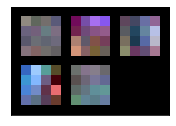

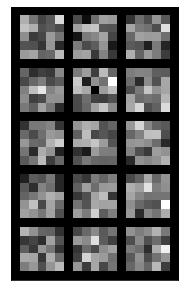

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torchvision import utils

def plotkernel(tensor, figname, ch=0, allkernels=False, nrow=3, padding=1):
    n, c, w, h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    fig, ax = plt.subplots( figsize=(nrow,rows))
    ax.imshow(grid.cpu().numpy().transpose((1, 2, 0)))
    plt.setp(ax, xticks=[], yticks=[])

    plt.savefig(figname)

for i, weights in enumerate([ml.model.conv1.weight.data.clone(), ml.model.conv2.weight.data.clone()]):
    plotkernel(weights, figname = 'figures/kernel_layer' + str(i) + '.png')

    